In [1]:
import matplotlib.pyplot as plt
import brian2 as br
from brian2 import meter, cm, mm, um, ms, us, volt, mV, uamp, ohm, uF
from brian2 import numpy as np

import pyoelectricity as pel

# Intro
This notebook demonstrates the use of _pyoelectricity.py_. The function _runImpactSimulation_ is used to calculate the impact of an homogenious external field, as well as the impact of the field generated by current point sources.


Please cite as:
> Schlötter Moritz, Maret Georg, Kleineidam Christoph J (2023) Annihilation of action potentials induces electrical coupling between neurons eLife 12:RP88335
>
> https://doi.org/10.7554/eLife.88335

# Homogenious field

In [2]:
target_morphology = br.Cylinder(diameter=1*um, x=[-100,100]*br.um, n=500)

In [3]:
v_ext_t = np.linspace(0, 3, 300)*ms
potential = br.linspace(0*volt, 1*volt, target_morphology.n)
v_ext_v = br.stack([potential/volt]*v_ext_t.shape[0]).T*volt
v_ext_v[:,v_ext_t<1*br.ms] = 0*br.volt
v_ext_v[:,v_ext_t>2*br.ms] = 0*br.volt

In [4]:
m_target_pel = pel.runImpactSimulation(v_ext_t=v_ext_t,
                                       v_ext_v=v_ext_v,
                                       morphology=target_morphology,
                                       Ri=1*ohm*meter)

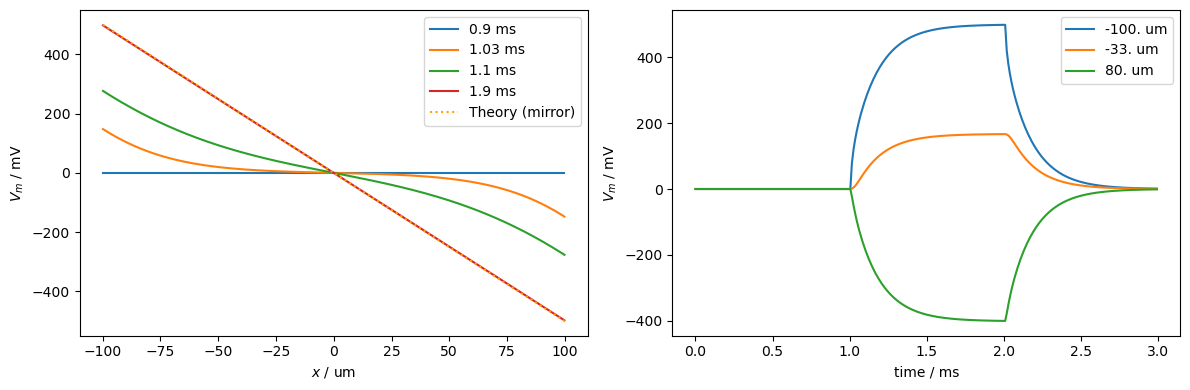

In [5]:
# Make plots
#with plt.style.context('plot_style.txt'):
cm_inch = 1/2.54
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

n_t = v_ext_t.shape[0]
def plt_at_t(t):
    i_t = br.argmin(br.absolute(v_ext_t-t))
    axs[0].plot(target_morphology.x/um, m_target_pel.v[:,i_t]/mV, label=m_target_pel.t[i_t].in_unit(ms,2))

plt_at_t(0.9*ms)
plt_at_t(1.03*ms)
plt_at_t(1.1*ms)
plt_at_t(1.9*ms)

mirror = -potential + potential.mean()
axs[0].plot(target_morphology.x/um, mirror/mV, ':', color='orange', label='Theory (mirror)')
axs[0].set_ylabel('$V_m$ / mV')
axs[0].set_xlabel('$x$ / um')
axs[0].legend()

n_x = target_morphology.n
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[0,:]/mV, label=target_morphology.x[0].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[n_x//3,:]/mV, label=target_morphology.x[n_x//3].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[n_x*9//10,:]/mV, label=target_morphology.x[n_x*9//10].in_unit(um, 0))
axs[1].set_ylabel('$V_m$ / mV')
axs[1].set_xlabel('time / ms')
axs[1].legend()

plt.tight_layout()

Test the similarity between charging and relaxation

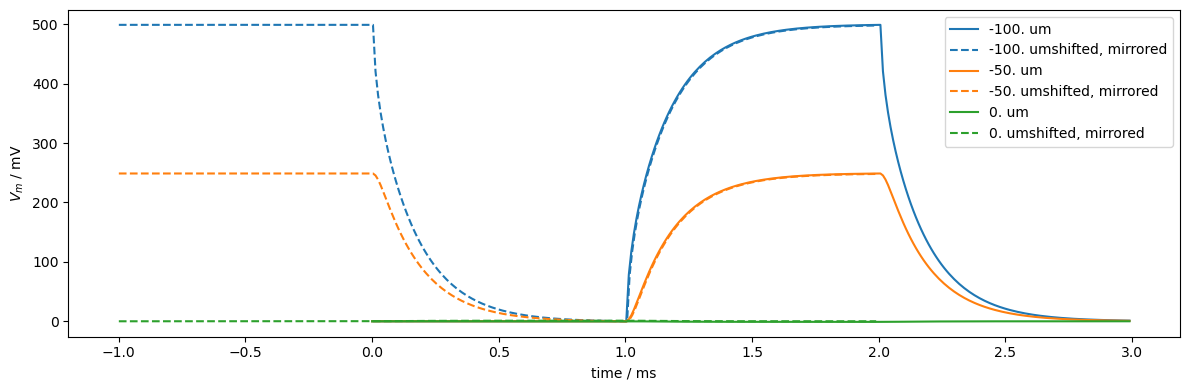

In [6]:
#Test relaxation
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

def doplt(i):
    ln = ax.plot(m_target_pel.t/ms, m_target_pel.v[i,:]/mV, label=target_morphology.x[i].in_unit(um, 0))
    maxval = max(m_target_pel.v[i,:]/mV)
    ax.plot(m_target_pel.t/ms -1, maxval-m_target_pel.v[i,:]/mV, '--',
            color=ln[0].get_color(), label=''+target_morphology.x[i].in_unit(um, 0)+'shifted, mirrored')
    
doplt(0)
doplt(125)
doplt(250)

ax.set_ylabel('$V_m$ / mV')
ax.set_xlabel('time / ms')
ax.legend()

plt.tight_layout()

# Central point source

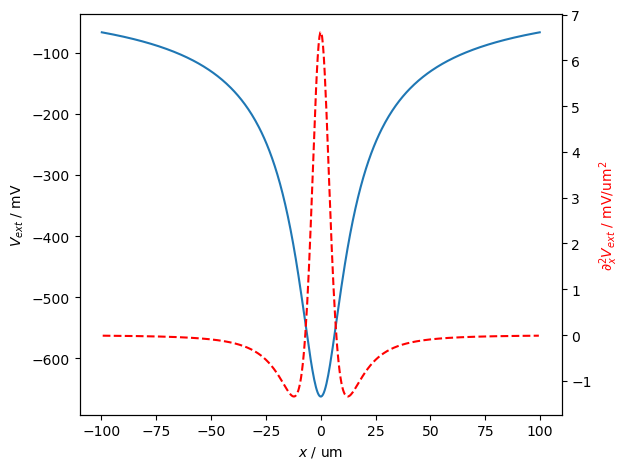

In [8]:
a_resists = pel.transfer_impedance_vc(0*mm, 10*um, 0*mm, 
                                      target_x=target_morphology.x,
                                      target_y=target_morphology.y,
                                      target_z=target_morphology.z)
ve_point = a_resists*-25*uamp
#def Ve_point_vc(t):
#    return ve_point

plt.plot(target_morphology.x/um, ve_point/mV)
plt.ylabel(r'$V_{ext}$ / mV')
plt.xlabel('$x$ / um')
plt.twinx()

af = np.diff(ve_point, n=2)/target_morphology.length[0]**2 #/ ricm
plt.plot(target_morphology.x[1:-1]/um, af/(mV/um**2), 'r--')
plt.ylabel(r'$\partial^2_x V_{ext}$ / mV/um$^2$', c='r')
plt.tight_layout()

In [9]:
v_ext_v = br.stack([ve_point/volt]*2).T*volt
v_ext_t = [0,1]*ms

m_target = pel.runImpactSimulation(v_ext_v=v_ext_v,
                                   v_ext_t=v_ext_t,
                                   morphology=target_morphology,
                                   simulation_duration=0.5*ms,
                                   dt=0.2*us)

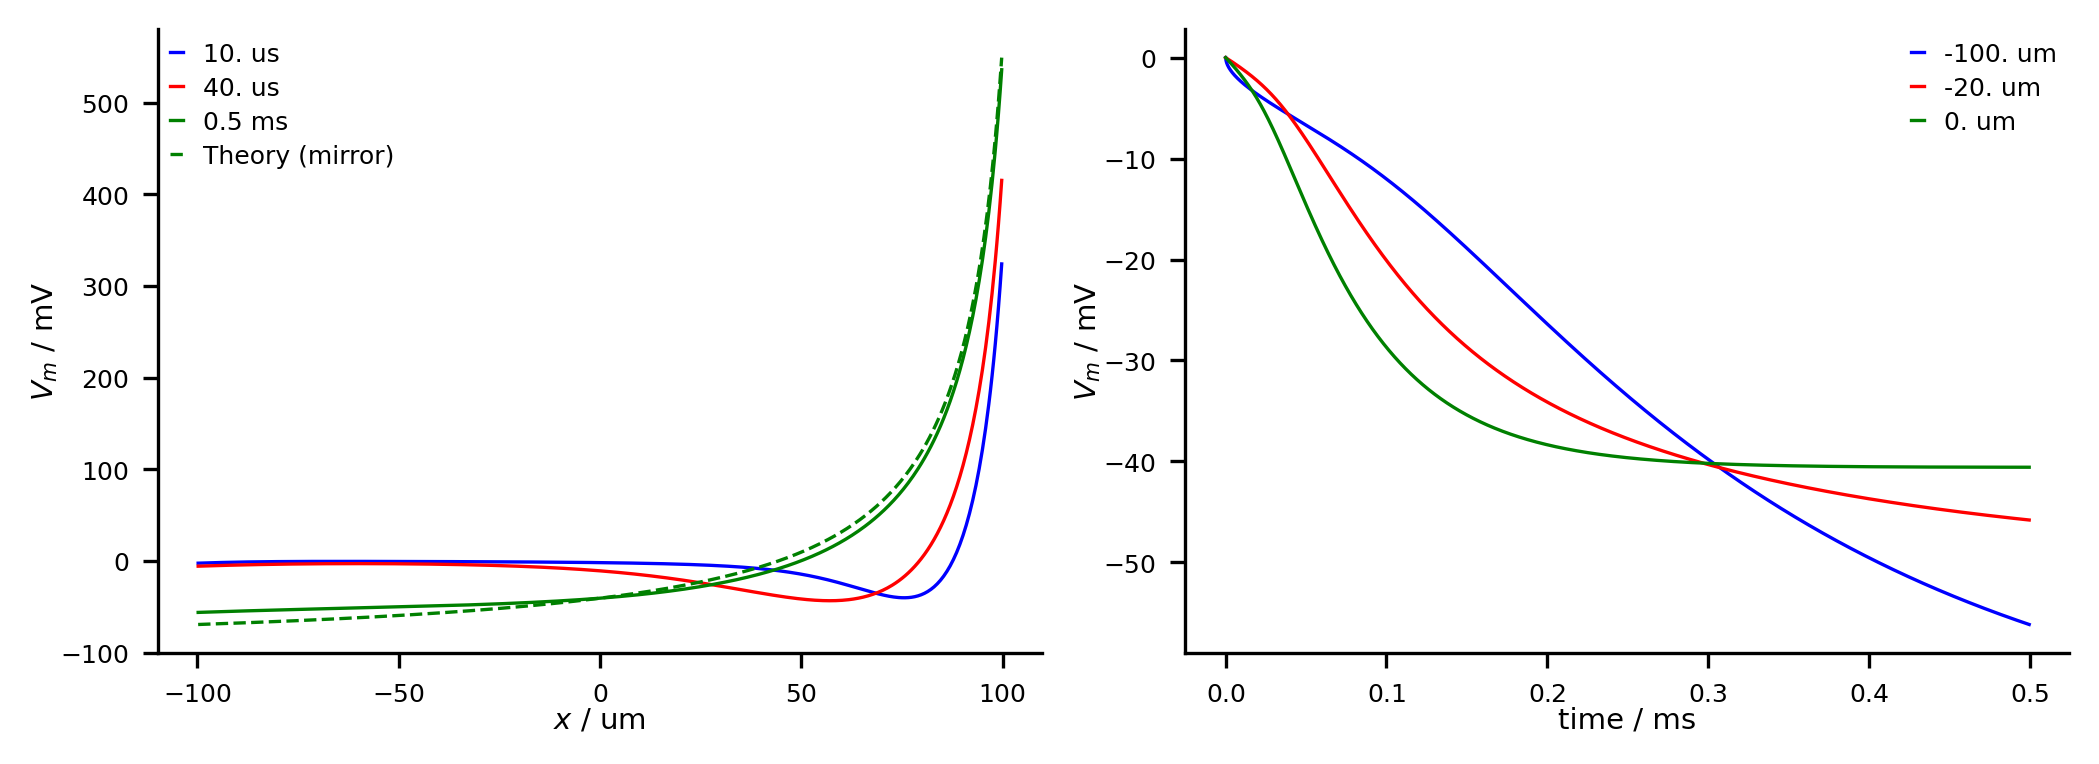

In [19]:
# Make plots

with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54
    fig, axs = plt.subplots(1, 2, figsize=(17.8*cm_inch, 6.5*cm_inch))

    axs[0].plot(target_morphology.x/um, m_target.v[:, 50]/mV, label=m_target.t[50])
    axs[0].plot(target_morphology.x/um, m_target.v[:, 200]/mV, label=m_target.t[200])
    axs[0].plot(target_morphology.x/um, m_target.v[:, -1]/mV, label=m_target.t[-1].in_unit(ms, 2))

    mirror = -ve_point + ve_point.mean()
    axs[0].plot(target_morphology.x/um, mirror/mV, '--', color='green', label='Theory (mirror)')
    axs[0].set_ylabel('$V_m$ / mV')
    axs[0].set_xlabel('$x$ / um')
    axs[0].legend()

    axs[1].plot(m_target.t/ms, m_target.v[0,:]/mV, label=target_morphology.x[0].in_unit(um, 0))
    axs[1].plot(m_target.t/ms, m_target.v[200,:]/mV, label=target_morphology.x[200].in_unit(um, 0))
    axs[1].plot(m_target.t/ms, m_target.v[250,:]/mV, label=target_morphology.x[250].in_unit(um, 0))

    axs[1].set_ylabel('$V_m$ / mV')
    axs[1].set_xlabel('time / ms')
    axs[1].legend(loc='best')#upper right')

    plt.tight_layout()

# Offset point source

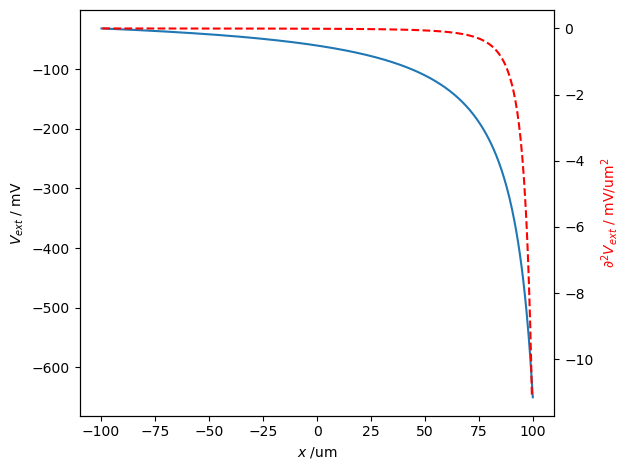

In [11]:
a_resists = pel.transfer_impedance_vc(110*um, 0*um, 0*um, 
                                      target_x=target_morphology.x,
                                      target_y=target_morphology.y,
                                      target_z=target_morphology.z)
ve_point = a_resists*-25*uamp
#def Ve_point_vc(t):
#    return ve_point

plt.plot(target_morphology.x/um, ve_point/mV)
plt.ylabel(r'$V_{ext}$ / mV')
plt.xlabel(r'$x$ /um')
plt.twinx()

af = np.diff(ve_point, n=2)/target_morphology.length[0]**2 #/ ricm
plt.plot(target_morphology.x[1:-1]/um, af/(mV/um**2), 'r--')
plt.ylabel(r'$\partial^2 V_{ext}$ / mV/um$^2$', c='r')
plt.tight_layout()

In [12]:
v_ext_v = br.stack([ve_point/volt]*2).T*volt
v_ext_t = [0,1]*ms

m_target = pel.runImpactSimulation(v_ext_v=v_ext_v,
                                   v_ext_t=v_ext_t,
                                   morphology=target_morphology,
                                   simulation_duration=0.5*ms,
                                   dt=0.2*us)

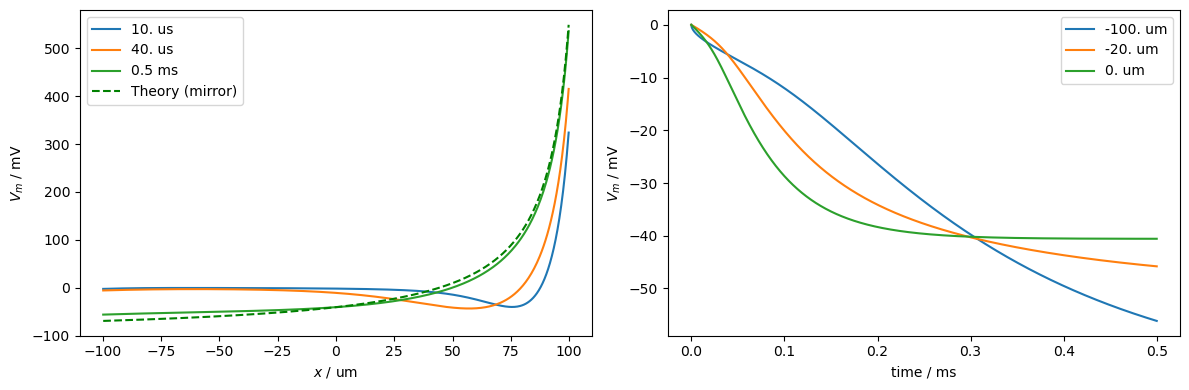

In [18]:
# Make plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(target_morphology.x/um, m_target.v[:, 50]/mV, label=m_target.t[50])
axs[0].plot(target_morphology.x/um, m_target.v[:, 200]/mV, label=m_target.t[200])
axs[0].plot(target_morphology.x/um, m_target.v[:, -1]/mV, label=m_target.t[-1].in_unit(ms, 2))

mirror = -ve_point + ve_point.mean()
axs[0].plot(target_morphology.x/um, mirror/mV, '--', color='green', label='Theory (mirror)')
axs[0].set_ylabel('$V_m$ / mV')
axs[0].set_xlabel('$x$ / um')
axs[0].legend()

axs[1].plot(m_target.t/ms, m_target.v[0,:]/mV, label=target_morphology.x[0].in_unit(um, 0))
axs[1].plot(m_target.t/ms, m_target.v[200,:]/mV, label=target_morphology.x[200].in_unit(um, 0))
axs[1].plot(m_target.t/ms, m_target.v[250,:]/mV, label=target_morphology.x[250].in_unit(um, 0))

axs[1].set_ylabel('$V_m$ / mV')
axs[1].set_xlabel('time / ms')
axs[1].legend(loc='upper right')
plt.tight_layout()